<a href="https://colab.research.google.com/github/BSouad/XRay-CovidPy/blob/main/Projet_COVID_PREPROCESSING_20220701.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***ACTIONS DE PREPROCESSING - APPLICATION DES CORRECTIONS DE LUMINOSITE ET CONTRASTE SUR LES IMAGES***
# MERCI DE NE PLUS EXECUTER CE NOTEBOOK :-)

## ***CREATION DES JEUX DE DONNEES***

**Importation des librairies Python et définition des chemin d'accès**

In [ ]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import shutil
import seaborn as sns
sns.set_theme()
import datetime
import cv2

from google.colab import drive
drive.mount('/content/drive')
chemin_donnees = '/content/drive/MyDrive/Colab Notebooks/FICHIERS CSV/'
chemin_images = '/content/drive/MyDrive/Colab Notebooks/IMAGES/'

#donnees_FULL = pd.read_csv(chemin_donnees + 'DataFrame JDD_FULL - 20220701.csv', sep=';', index_col=0)
#donnees_FULL = pd.read_csv(chemin_donnees + 'DataFrame JDD_FULL_Cropped_LumCorr - 20220701.csv', sep=';', index_col=0)
#donnees_800 = pd.read_csv(chemin_donnees + 'DataFrame JDD_800 - 20220701.csv', sep=';', index_col=0)
#donnees_800 = pd.read_csv(chemin_donnees + 'DataFrame JDD_800_Cropped_LumCorr - 20220701.csv', sep=';', index_col=0)

Mounted at /content/drive


**Construction du JDD complet (21615 images)**

In [ ]:
#ON IMPORTE LES DONNEES A PARTIR DES 4 FICHIERS CSV ORIGINAUX
df1 = pd.read_csv(chemin_donnees + 'COVID.metadata.csv', sep=';')
df2 = pd.read_csv(chemin_donnees + 'Lung_Opacity.metadata.csv', sep=';')
df3 = pd.read_csv(chemin_donnees + 'Normal.metadata.csv', sep=';')
df4 = pd.read_csv(chemin_donnees + 'Viral Pneumonia.metadata.csv', sep=';')

#ON RAJOUTE UNE COLONNE 'TYPE' PUIS ON FUSIONNE LES 4 CSV DANS UN DATAFRAME UNIQUE
df1['TYPE'] = 'COVID'
df2['TYPE'] = 'Lung_Opacity'
df3['TYPE'] = 'Normal'
df4['TYPE'] = 'Viral Pneumonia'
donnees_FULL = pd.concat([df1, df2, df3, df4], ignore_index=True)

#ON SUPPRIME 2 COLONNES INUTILES ET ON AJOUTE UNE COLONNE 'FICHIER' AVEC LE CHEMIN COMPLET DES IMAGES
donnees_FULL.drop(['FORMAT','SIZE'], axis=1, inplace=True)
donnees_FULL = donnees_FULL.assign(FICHIER=lambda x: chemin_images + 'PHOTOS ORIGINALES/' + x.TYPE + '/' + x['FILE NAME'] + '.png')

donnees_FULL['LUMINOSITE'] = np.nan
donnees_FULL['LUMINOSITE-CORR'] = np.nan
donnees_FULL['CONTRASTE'] = np.nan
donnees_FULL['CONTRASTE-CORR'] = np.nan

#On sauvegarde le DataFrame dans un CSV
donnees_FULL.to_csv(chemin_donnees + 'DataFrame JDD_FULL - 20220701.csv', sep=';')
donnees_FULL

,FILE NAME,URL,TYPE,FICHIER,LUMINOSITE,LUMINOSITE-CORR,CONTRASTE,CONTRASTE-CORR
0,COVID-1,https://sirm.org/category/senza-categoria/covi...,COVID,/content/drive/MyDrive/Colab Notebooks/IMAGES/...,NaN,NaN,NaN,NaN
1,COVID-2,https://sirm.org/category/senza-categoria/covi...,COVID,/content/drive/MyDrive/Colab Notebooks/IMAGES/...,NaN,NaN,NaN,NaN
2,COVID-3,https://sirm.org/category/senza-categoria/covi...,COVID,/content/drive/MyDrive/Colab Notebooks/IMAGES/...,NaN,NaN,NaN,NaN
3,COVID-4,https://sirm.org/category/senza-categoria/covi...,COVID,/content/drive/MyDrive/Colab Notebooks/IMAGES/...,NaN,NaN,NaN,NaN
4,COVID-5,https://sirm.org/category/senza-categoria/covi...,COVID,/content/drive/MyDrive/Colab Notebooks/IMAGES/...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
21160,Viral Pneumonia-1341,https://www.kaggle.com/paultimothymooney/chest...,Viral Pneumonia,/content/drive/MyDrive/Colab Notebooks/IMAGES/...,NaN,NaN,NaN,NaN
21161,Viral Pneumonia-1342,https://www.kaggle.com/paultimothymooney/chest...,Viral Pneumonia,/content/drive/MyDrive/Colab Notebooks/IMAGES/...,NaN,NaN,NaN,NaN
21162,Viral Pneumonia-1343,https://www.kaggle.com/paultimothymooney/chest...,Viral Pneumonia,/content/drive/MyDrive/Colab Notebooks/IMAGES/...,NaN,NaN,NaN,NaN
21163,Viral Pneumonia-1344,https://www.kaggle.com/paultimothymooney/chest...,Viral Pneumonia,/content/drive/MyDrive/Colab Notebooks/IMAGES/...,NaN,NaN,NaN,NaN


**Construction du JDD réduit (4x200 images)**

In [ ]:
#Fonction qui construit un JDD réduit en prélevant nb images de chaque type
def creerJDD(df, nb):
    types = ['Normal','Lung_Opacity','COVID','Viral Pneumonia']
    for ityp in range(4):
        listetoremove = df.index[(df.TYPE==types[ityp])].tolist()
        df.TYPE.value_counts()
        for isup in range(nb):
            valtoremove = np.random.randint(0,len(listetoremove))
            listetoremove.pop(valtoremove)
        df.drop(listetoremove, inplace=True)
    return df
donnees_800 = creerJDD(donnees_FULL.copy(),200)


#Autre méthode pour récupérer les mêmes 800 images que dans un ancien JDD
donnees_800_old = pd.read_csv(chemin_donnees + 'DataFrame JDD_800 - 20220701.csv', sep=';', index_col=0)
donnees_800 = donnees_FULL.copy()
listetokeep = donnees_800_old['FILE NAME'].tolist()
for index in range(21615):
    if donnees_800['FILE NAME'][index] not in listetokeep:
        donnees_800.drop(index, inplace=True)


## ATTENTION : l'index du nouveau dataframe donnees_800 est "troué", pour accéder à la i-ème valeur, il faut utiliser la syntaxe suivante : donnees_800.FICHIER[donnees_800.index[i]] au lieu de donnees_800.FICHIER[i]


#On détermine le chemin cible pour dupliquer les 800 images depuis le dossier original complet
equivalence = {'/PHOTOS ORIGINALES/COVID/'            : '/JDD_800/',
               '/PHOTOS ORIGINALES/Lung_Opacity/'     : '/JDD_800/',
               '/PHOTOS ORIGINALES/Normal/'           : '/JDD_800/',
               '/PHOTOS ORIGINALES/Viral Pneumonia/'  : '/JDD_800/'}
donnees_800['FICHIER2'] = donnees_800.FICHIER.replace(equivalence, regex=True)

#On duplique les images
for index in range(800):
    filePath = shutil.copy(donnees_800.FICHIER.iloc[index], donnees_800.FICHIER2.iloc[index])

#On supprime l'ancien chemin et on pérennise le nouveau chemin
donnees_800.FICHIER = donnees_800.FICHIER2
donnees_800.drop('FICHIER2', axis=1, inplace=True)

#On sauvegarde le DataFrame dans un CSV
donnees_800.to_csv(chemin_donnees + 'DataFrame JDD_800 - 20220701.csv', sep=';')
donnees_800

,FILE NAME,URL,TYPE,FICHIER,LUMINOSITE,LUMINOSITE-CORR,CONTRASTE,CONTRASTE-CORR
16,COVID-17,https://sirm.org/category/senza-categoria/covi...,COVID,/content/drive/MyDrive/Colab Notebooks/IMAGES/...,NaN,NaN,NaN,NaN
26,COVID-27,https://sirm.org/category/senza-categoria/covi...,COVID,/content/drive/MyDrive/Colab Notebooks/IMAGES/...,NaN,NaN,NaN,NaN
33,COVID-34,https://sirm.org/category/senza-categoria/covi...,COVID,/content/drive/MyDrive/Colab Notebooks/IMAGES/...,NaN,NaN,NaN,NaN
36,COVID-37,https://sirm.org/category/senza-categoria/covi...,COVID,/content/drive/MyDrive/Colab Notebooks/IMAGES/...,NaN,NaN,NaN,NaN
41,COVID-42,https://sirm.org/category/senza-categoria/covi...,COVID,/content/drive/MyDrive/Colab Notebooks/IMAGES/...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
21130,Viral Pneumonia-1311,https://www.kaggle.com/paultimothymooney/chest...,Viral Pneumonia,/content/drive/MyDrive/Colab Notebooks/IMAGES/...,NaN,NaN,NaN,NaN
21138,Viral Pneumonia-1319,https://www.kaggle.com/paultimothymooney/chest...,Viral Pneumonia,/content/drive/MyDrive/Colab Notebooks/IMAGES/...,NaN,NaN,NaN,NaN
21145,Viral Pneumonia-1326,https://www.kaggle.com/paultimothymooney/chest...,Viral Pneumonia,/content/drive/MyDrive/Colab Notebooks/IMAGES/...,NaN,NaN,NaN,NaN
21147,Viral Pneumonia-1328,https://www.kaggle.com/paultimothymooney/chest...,Viral Pneumonia,/content/drive/MyDrive/Colab Notebooks/IMAGES/...,NaN,NaN,NaN,NaN


## ***REDUCTION DE DIMENSIONS : On élimine les bords noirs des images afin de se concentrer sur les zones utiles***

**Définition des fonctions**

In [ ]:
#Fonction qui calcule la largeur "brute" des bords noirs d'une image, cad le nb de lignes/colonnes dont au moins 50% des pixels sont < 20
def calculeBordsNoirs(image):
    nbPixels = image.shape[0]
    xmin, xmax, ymin, ymax = (0,0,0,0)
    seuilNoir = 10
    pctage = 0.5 * nbPixels
    for i in range(0,nbPixels//4):
        if (image[:,i]<seuilNoir).sum() > pctage: xmin = i
        if (image[:,nbPixels-1-i]<seuilNoir).sum() > pctage: xmax = i
        if (image[i,:]<seuilNoir).sum() > pctage: ymin = i
        if (image[nbPixels-1-i,:]<seuilNoir).sum() > pctage: ymax = i
    return xmin, xmax, ymin, ymax

In [ ]:
#Fonction qui calcule les bords corrigés d'une image, en prenant en compte l'épaisseur des bords noirs bruts et le fait de conserver une forme carrée
def calculeBordsCorriges(image):
    nbPixels = image.shape[0]
    xmin, xmax, ymin, ymax = calculeBordsNoirs(image)
    xmin_d, xmax_d, ymin_d, ymax_d = (0, 0, 0, 0)
    
    #Si les bords noirs sont déséquilibrés entre H et V, on se rabat sur la plus petite valeur afin de conserver les proportions de l'image initiale
    nbcrop = min(xmin + xmax, ymin + ymax)
    
    xmin_d = min(xmin, nbcrop)
    xmax_d = nbPixels - 1 - (nbcrop - xmin_d)
    ymin_d = min(ymin, nbcrop)
    ymax_d = nbPixels - 1 - (nbcrop - ymin_d)
    return xmin_d, xmax_d, ymin_d, ymax_d

In [ ]:
#Fonction qui élimine les bords noirs d'un JDD. Pour chaque image :
#  on calcule sa luminosité et son contraste actuel qu'on stocke dans le dataframe,
#  on calcule la dimension des bords noirs,
#  on effectue un cropping en conservant une forme carrée,
#  on la redimensionne à la taille 299x299,
#  on calcule sa nouvelle luminosité et son nouveau contraste qu'on stocke dans le dataframe,
#  enfin, on enregistre la nouvelle image dans un nouveau dossier
def croppeImages(df, nouveauChemin):
    df['FICHIERold'] = df.FICHIER.copy()
    df.FICHIER = df.FICHIER.replace(nouveauChemin, regex = True)
    for inum in range(len(df)):
        indx = df.index[inum]
        img = cv2.imread(df.FICHIERold[indx], cv2.IMREAD_GRAYSCALE)
        xmin_d, xmax_d, ymin_d, ymax_d = calculeBordsCorriges(img)
        img_cropped = img[ymin_d:ymax_d, xmin_d:xmax_d]

        dim = (img.shape[0], img.shape[1])
        img_resized = cv2.resize(img_cropped, dim, interpolation = cv2.INTER_AREA)

        mini, maxi = int(img.min()), int(img.max())
        df.loc[indx, 'LUMINOSITE'] = img.mean()
        df.loc[indx, 'CONTRASTE'] = (maxi-mini)/(maxi+mini)

        mini, maxi = int(img_resized.min()), int(img_resized.max())
        df.loc[indx, 'LUMINOSITE-CORR'] = img_resized.mean()
        df.loc[indx, 'CONTRASTE-CORR'] = (maxi-mini)/(maxi+mini)

        cv2.imwrite(df.FICHIER[indx], img_resized)
    return df.drop('FICHIERold', axis=1)

In [ ]:
#Fonction qui applique la correction de luminosité aux images du JDD en fonction de leur classe
#  On calcule la luminosité moyenne de tout le JDD et celles de chaque classe
#  Puis on corrige chaque image, et on recalcule la luminosité et le contraste corrigés
#  Enfin, on créé une sauvegarde de l'image
def CorrectionLum(df):
    moy_global = df['LUMINOSITE-CORR'].mean()
    for inum in range(len(df)):
        indx = df.index[inum]
        img = cv2.imread(df.FICHIER[indx], cv2.IMREAD_GRAYSCALE)
        
        moy_local = df[(df.TYPE==df.TYPE[indx])]['LUMINOSITE-CORR'].mean()
        
        img_corr = img - moy_local + moy_global
        img_corr[img_corr<0] = 0      #Correction des valeurs aberrantes
        img_corr[img_corr>255] = 255  #Correction des valeurs aberrantes

        mini, maxi = int(img_corr.min()), int(img_corr.max())
        df.loc[indx, 'LUMINOSITE-CORR'] = img_corr.mean()
        df.loc[indx, 'CONTRASTE-CORR'] = (maxi-mini)/(maxi+mini)
    
        cv2.imwrite(df.FICHIER[indx], img_corr)
    return df

**Test d'élimination des bords noirs sur une image**

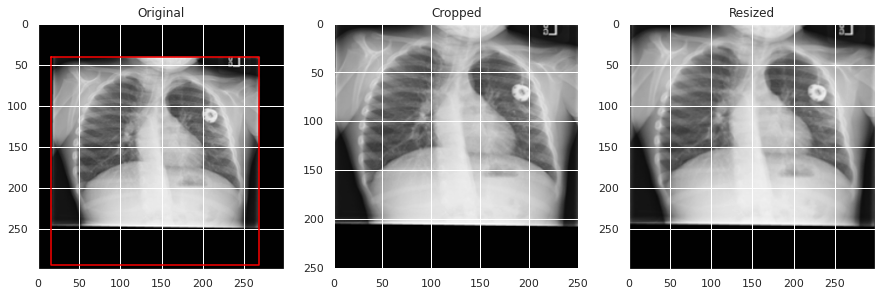

In [ ]:
#Test sur 1 image : on calcule la dimension des bords noirs, puis on effectue un cropping en conservant une forme carrée, enfin on redimensionne à la taille 299x299
#num = np.random.randint(0,800)
num = donnees_800.index[502]
img = cv2.imread(donnees_FULL.FICHIER[num], cv2.IMREAD_GRAYSCALE)
xmin_d, xmax_d, ymin_d, ymax_d = calculeBordsCorriges(img)
img_cropped = img[ymin_d:ymax_d, xmin_d:xmax_d]
dim = (img.shape[0], img.shape[1])
img_resized = cv2.resize(img_cropped, dim, interpolation = cv2.INTER_AREA)

fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(131)
ax1.imshow(img, cmap = 'gray')
ax1.set_title('Original')
ax1.plot([xmin_d, xmax_d, xmax_d, xmin_d, xmin_d], [ymin_d, ymin_d, ymax_d, ymax_d, ymin_d], color='red')

ax1 = fig.add_subplot(132)
ax1.imshow(img_cropped, cmap = 'gray')
ax1.set_title('Cropped')
ax1 = fig.add_subplot(133)
ax1.imshow(img_resized, cmap = 'gray')
ax1.set_title('Resized');

**Cropping et calcul des luminosités sur le JDD 800**

In [ ]:
donnees_800 = pd.read_csv(chemin_donnees + 'DataFrame JDD_800 - 20220701.csv', sep=';', index_col=0)

#On applique la fonction au JDD 800 :
newPath = {'/JDD_800/' : '/JDD_800_LumCorr_Cropped/'}
donnees_800 = croppeImages(donnees_800,newPath)

#On conserve l'emplacement des images modifiées dans le DataFrame que l'on enregistre
donnees_800.to_csv(chemin_donnees + 'DataFrame JDD_800_Cropped - 20220701.csv', sep=';')
print('Traitement terminé')

Traitement terminé


**Cropping et calcul des luminosités sur le JDD FULL**

In [ ]:
donnees_FULL = pd.read_csv(chemin_donnees + 'DataFrame JDD_FULL - 20220701.csv', sep=';', index_col=0)

#On applique la fonction au JDD FULL :
newPath = {'/PHOTOS ORIGINALES/COVID/'            : '/JDD_ALL_LumCorr_Cropped/',
           '/PHOTOS ORIGINALES/Lung_Opacity/'     : '/JDD_ALL_LumCorr_Cropped/',
           '/PHOTOS ORIGINALES/Normal/'           : '/JDD_ALL_LumCorr_Cropped/',
           '/PHOTOS ORIGINALES/Viral Pneumonia/'  : '/JDD_ALL_LumCorr_Cropped/'}
donnees_FULL = croppeImages(donnees_FULL, newPath)

#On conserve l'emplacement des images modifiées dans le DataFrame que l'on enregistre
donnees_FULL.to_csv(chemin_donnees + 'DataFrame JDD_FULL_Cropped - 20220701.csv', sep=';')
print('Traitement terminé')

Traitement terminé


**Uniformisation des luminosités sur les images croppées du JDD 800**

In [ ]:
#On applique la fonction au JDD 800 :
donnees_800 = CorrectionLum(donnees_800)

#On conserve les nouvelles luminosités et contrastes corrigés dans le DataFrame que l'on enregistre
donnees_800.to_csv(chemin_donnees + 'DataFrame JDD_800_Cropped_LumCorr - 20220701.csv', sep=';')
print('Traitement terminé')

Traitement terminé


**Uniformisation des luminosités sur les images croppées du JDD FULL**

In [ ]:
#On applique la fonction au JDD FULL :
donnees_FULL = CorrectionLum(donnees_FULL)

#On conserve les nouvelles luminosités et contrastes corrigés dans le DataFrame que l'on enregistre
donnees_FULL.to_csv(chemin_donnees + 'DataFrame JDD_FULL_Cropped_LumCorr - 20220701.csv', sep=';')
print('Traitement terminé')

Traitement terminé


**Verification en images : JDD 800**

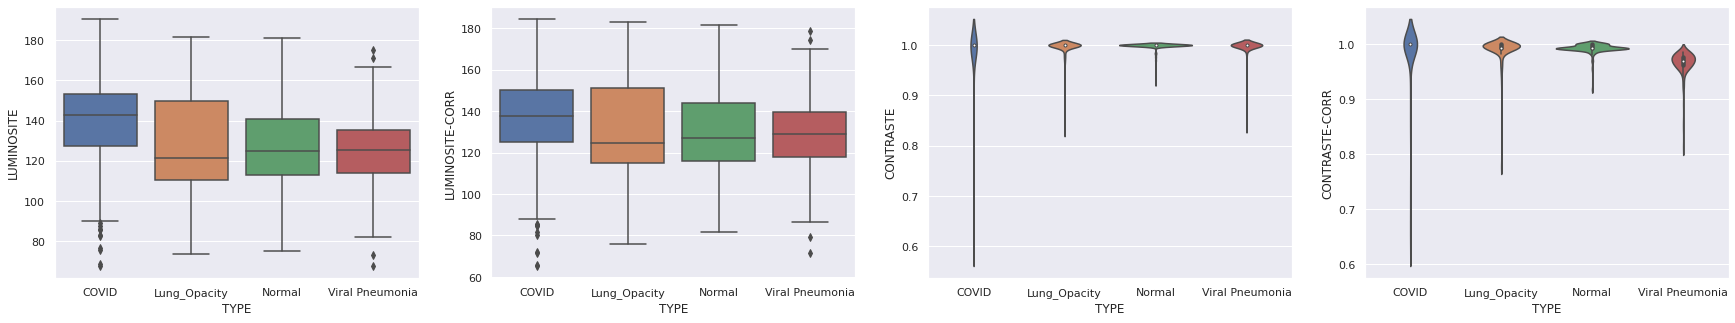

In [ ]:
#On affiche l'impact de la modification sur les 4 classes
fig, axes = plt.subplots(1,4,  figsize=(30,5))
sns.boxplot(ax=axes[0],x='TYPE', y='LUMINOSITE', data=donnees_800)
sns.boxplot(ax=axes[1],x='TYPE', y='LUMINOSITE-CORR', data=donnees_800)
sns.violinplot(ax=axes[2],x='TYPE', y='CONTRASTE', data=donnees_800)
sns.violinplot(ax=axes[3],x='TYPE', y='CONTRASTE-CORR', data=donnees_800);

**Verification en images : JDD FULL**

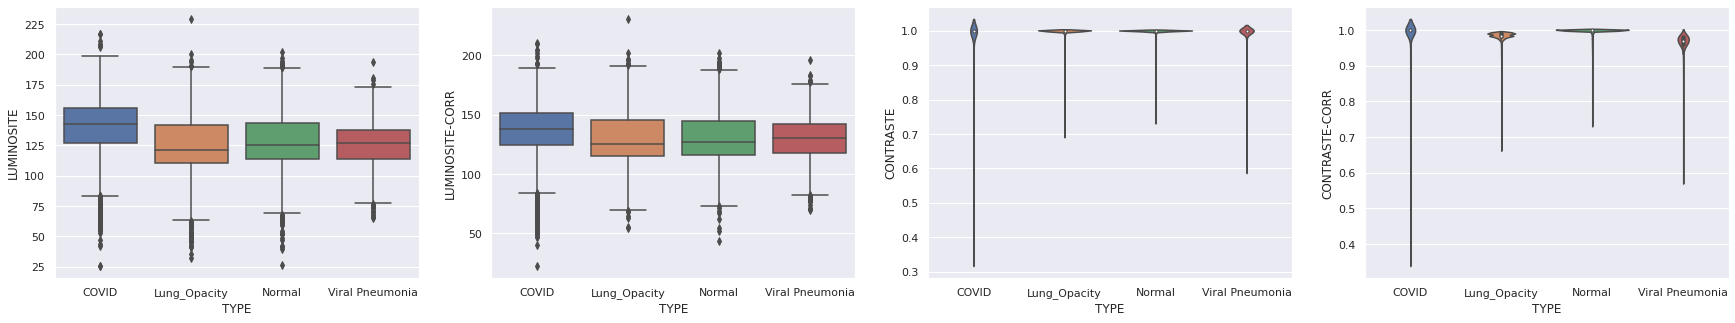

In [ ]:
#On affiche l'impact de la modification sur les 4 classes
fig, axes = plt.subplots(1,4,  figsize=(30,5))
sns.boxplot(ax=axes[0], x='TYPE', y='LUMINOSITE', data=donnees_FULL)
sns.boxplot(ax=axes[1], x='TYPE', y='LUMINOSITE-CORR', data=donnees_FULL)
sns.violinplot(ax=axes[2], x='TYPE', y='CONTRASTE', data=donnees_FULL)
sns.violinplot(ax=axes[3], x="TYPE", y="CONTRASTE-CORR", data=donnees_FULL);
#sns.boxplot(ax=axes[3], x='TYPE', y='CONTRASTE-CORR', data=donnees_FULL);

**Visualisation des corrections de luminosité**

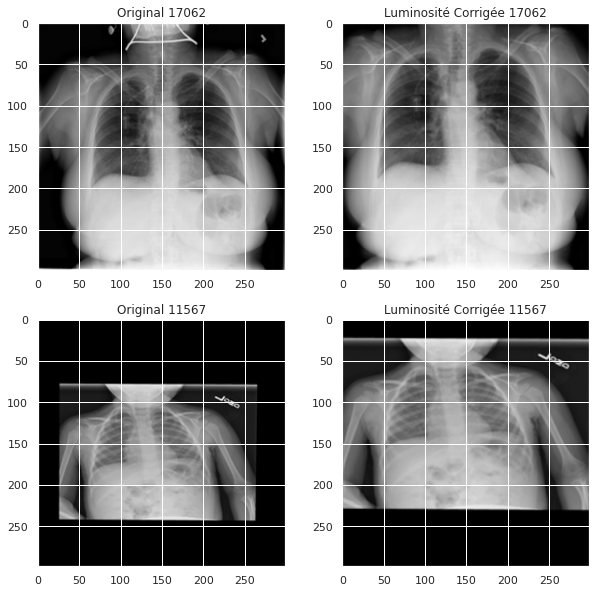

In [ ]:
#Test sur 2 images : Visualisation des corrections de luminosité

donnees_FULL_orig = pd.read_csv(chemin_donnees + 'DataFrame JDD_FULL - 20220701.csv', sep=';', index_col=0)
donnees_FULL_corr = pd.read_csv(chemin_donnees + 'DataFrame JDD_FULL_Cropped_LumCorr - 20220701.csv', sep=';', index_col=0)

num = 17062 #np.random.randint(0,21615)
img = cv2.imread(donnees_FULL_orig.FICHIER[num], cv2.IMREAD_GRAYSCALE)
img_corr = cv2.imread(donnees_FULL_corr.FICHIER[num], cv2.IMREAD_GRAYSCALE)

fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(221)
ax1.imshow(img, cmap = 'gray')
ax1.set_title('Original ' + str(num))
ax1 = fig.add_subplot(222)
ax1.imshow(img_corr, cmap = 'gray')
ax1.set_title('Luminosité Corrigée ' + str(num))

num = 11567 #np.random.randint(0,21615)
img = cv2.imread(donnees_FULL_orig.FICHIER[num], cv2.IMREAD_GRAYSCALE)
img_corr = cv2.imread(donnees_FULL_corr.FICHIER[num], cv2.IMREAD_GRAYSCALE)
ax1 = fig.add_subplot(223)
ax1.imshow(img, cmap = 'gray')
ax1.set_title('Original ' + str(num))
ax1 = fig.add_subplot(224)
ax1.imshow(img_corr, cmap = 'gray')
ax1.set_title('Luminosité Corrigée ' + str(num));

## ***GRADCAM***

**On définit les fonctions nécessaire à la mise en place du GradCam:**



In [ ]:
#Le code pour mettre en place le gradcam est issu de https://keras.io/examples/vision/grad_cam/
import tensorflow as tf
from tensorflow import keras

from IPython.display import Image, display
import matplotlib.cm as cm

#Configuration des paramètres

model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

In [ ]:
#Fonction qui transforme une image en array 
def get_img_array(img_path, size):
    #On stock l'image dans img
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # on transforme l'image en array de shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # on rajoute une dimension pour transformer l'array en  "batch" de taille (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


#Fonction qui retourne la heatmap de la gradcam
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


#Fonction qui superpose le gradcam à l'image
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # on charge l'image originale
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # on escale le heatmap 
    heatmap = np.uint8(255 * heatmap)

    # On utilise jet colormap pour colorier la heatmap
    jet = cm.get_cmap("jet")

    # On utilise les valeurs RGB pour la colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # On crée l'image avec une heatmap RGB
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # On superpose la heatmap à l'image originale
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # on sauvegarde l'image superposée
    superimposed_img.save(cam_path)

    # On affiche la GradCam
    display(Image(cam_path))

**On applique 2 Gradcam sur le jeu de données :**

* **une première fois sur l'image originale**

* **ensuite, sur l'image après cropping et uniformisation de la luminosité**

In [ ]:
#On importe les jeux de données réduits (800) avant et après preprocessing:

donnees_800 = pd.read_csv(chemin_donnees + 'DataFrame JDD_800 - 20220701.csv', sep=';', index_col=0)
donnees_800_corr = pd.read_csv(chemin_donnees + 'DataFrame JDD_800_Cropped_LumCorr - 20220701.csv', sep=';', index_col=0)

In [ ]:
donnees_800.head()

,FILE NAME,URL,TYPE,FICHIER,LUMINOSITE,LUMINOSITE-CORR,CONTRASTE,CONTRASTE-CORR
16,COVID-17,https://sirm.org/category/senza-categoria/covi...,COVID,/content/drive/MyDrive/Colab Notebooks/IMAGES/...,NaN,NaN,NaN,NaN
26,COVID-27,https://sirm.org/category/senza-categoria/covi...,COVID,/content/drive/MyDrive/Colab Notebooks/IMAGES/...,NaN,NaN,NaN,NaN
33,COVID-34,https://sirm.org/category/senza-categoria/covi...,COVID,/content/drive/MyDrive/Colab Notebooks/IMAGES/...,NaN,NaN,NaN,NaN
36,COVID-37,https://sirm.org/category/senza-categoria/covi...,COVID,/content/drive/MyDrive/Colab Notebooks/IMAGES/...,NaN,NaN,NaN,NaN
41,COVID-42,https://sirm.org/category/senza-categoria/covi...,COVID,/content/drive/MyDrive/Colab Notebooks/IMAGES/...,NaN,NaN,NaN,NaN


49152/38198 [======================================] - 0s 0us/step
Normal


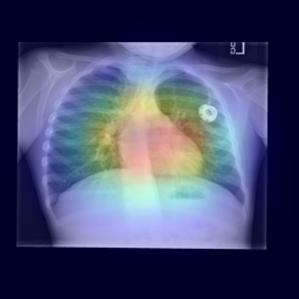

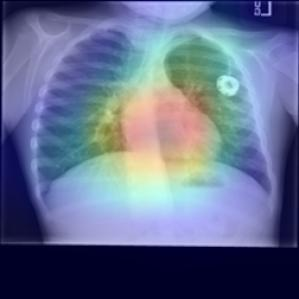

In [ ]:
#on remplace le nom de la colonne "FILE NAME" pour des raisons pratiques 
dictionary = {'FILE NAME': 'FILENAME'}
donnees_800 = donnees_800.rename(dictionary, axis = 1)
donnees_800_corr = donnees_800_corr.rename(dictionary, axis = 1)


#num = np.random.randint(0,800)
num=502

#On importe les 3 images à comparer: 
img_original = keras.utils.get_file(donnees_800.FILENAME[donnees_800.index[num]]+"-ORIG.jpg", 'file://'+donnees_800.FICHIER[donnees_800.index[num]])
img_cropped_lum = keras.utils.get_file(donnees_800_corr.FILENAME[donnees_800_corr.index[num]]+"-CROPLUM.jpg", 'file://'+donnees_800_corr.FICHIER[donnees_800_corr.index[num]])


#on convertit les images en array en utilisant la fonction précédemment définie  et on prépare la heatmap et le modèle
img_array_original = preprocess_input(get_img_array(img_original, size=img_size))
img_array_cropped_lum = preprocess_input(get_img_array(img_cropped_lum, size=img_size))


model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

heatmap1 = make_gradcam_heatmap(img_array_original, model, last_conv_layer_name)
heatmap3 = make_gradcam_heatmap(img_array_cropped_lum, model, last_conv_layer_name)

print(donnees_800.TYPE[donnees_800.index[num]])
save_and_display_gradcam(img_original, heatmap1)
save_and_display_gradcam(img_cropped_lum, heatmap3)